<a href="https://colab.research.google.com/github/RoOboOcoOp/Calculo-de-Metricas-de-Avaliacao-de-Aprendizado/blob/main/Matriz_de_Confus%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow==2.20.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00


In [2]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns

import pandas as pd
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [3]:
tf.__version__

'2.20.0'

In [4]:
%load_ext tensorboard

In [5]:
logdir='log'

In [6]:
# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Build model
model = models.Sequential()
model.add(layers.Input(shape=(28, 28, 1)))  # Add Input layer first
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [8]:
# Compile and train model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
          y=train_labels,
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.8968 - loss: 0.3356 - val_accuracy: 0.9838 - val_loss: 0.0522
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9847 - loss: 0.0496 - val_accuracy: 0.9826 - val_loss: 0.0549
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9900 - loss: 0.0324 - val_accuracy: 0.9877 - val_loss: 0.0384
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.9921 - loss: 0.0249 - val_accuracy: 0.9902 - val_loss: 0.0324
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 0.9888 - val_loss: 0.0333


In [9]:
# Get predictions
y_true = test_labels
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [10]:
# Calculate accuracy manually
accuracy = np.mean(y_true == y_pred)
print(f"Manual Accuracy: {accuracy:.4f}")

Manual Accuracy: 0.9888


In [11]:
# Calculate precision, recall, and F1 for each class
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
total_samples = np.sum(con_mat)

precision_scores = []
recall_scores = []
f1_scores = []
supports = []
tn_scores = []
acc_scores = []
spec_scores = []  # Changed from esp_scores to spec_scores for clarity

for i in range(len(classes)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP

    # Calculate TN for class i
    TN = total_samples - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    acc = (TP + TN) / total_samples
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity
    support = np.sum(con_mat[i, :])

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    supports.append(support)
    tn_scores.append(TN)
    acc_scores.append(acc)
    spec_scores.append(spec)  # Changed from esp_scores to spec_scores

    # Fixed print statement to use current values instead of entire lists
    print(f"Class {i}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Support={support}, TN={TN}, Accuracy={acc:.4f}, Specificity={spec:.4f}")


Class 0: Precision=0.9919, Recall=0.9969, F1=0.9944, Support=980, TN=9012, Accuracy=0.9989, Specificity=0.9991
Class 1: Precision=0.9973, Recall=0.9753, F1=0.9862, Support=1135, TN=8862, Accuracy=0.9969, Specificity=0.9997
Class 2: Precision=0.9828, Recall=0.9952, F1=0.9889, Support=1032, TN=8950, Accuracy=0.9977, Specificity=0.9980
Class 3: Precision=0.9911, Recall=0.9941, F1=0.9926, Support=1010, TN=8981, Accuracy=0.9985, Specificity=0.9990
Class 4: Precision=0.9919, Recall=0.9959, F1=0.9939, Support=982, TN=9010, Accuracy=0.9988, Specificity=0.9991
Class 5: Precision=0.9932, Recall=0.9843, F1=0.9887, Support=892, TN=9102, Accuracy=0.9980, Specificity=0.9993
Class 6: Precision=0.9948, Recall=0.9906, F1=0.9927, Support=958, TN=9037, Accuracy=0.9986, Specificity=0.9994
Class 7: Precision=0.9912, Recall=0.9844, F1=0.9878, Support=1028, TN=8963, Accuracy=0.9975, Specificity=0.9990
Class 8: Precision=0.9602, Recall=0.9897, F1=0.9747, Support=974, TN=8986, Accuracy=0.9950, Specificity=0.99

In [12]:
# Calculate weighted averages
weighted_precision = np.sum(np.array(precision_scores) * np.array(supports)) / np.sum(supports)
weighted_recall = np.sum(np.array(recall_scores) * np.array(supports)) / np.sum(supports)
weighted_f1 = np.sum(np.array(f1_scores) * np.array(supports)) / np.sum(supports)
weighted_accuracy = np.sum(np.array(acc_scores) * np.array(supports)) / np.sum(supports)
weighted_specificity = np.sum(np.array(spec_scores) * np.array(supports)) / np.sum(supports)


print(f"\nWeighted Average Precision: {weighted_precision:.4f}")
print(f"Weighted Average Recall: {weighted_recall:.4f}")
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")
print(f"Weighted Average F1: {weighted_f1:.4f}")


Weighted Average Precision: 0.9889
Weighted Average Recall: 0.9888
Weighted Accuracy: 0.9977
Weighted Specificity: 0.9988
Weighted Average F1: 0.9888


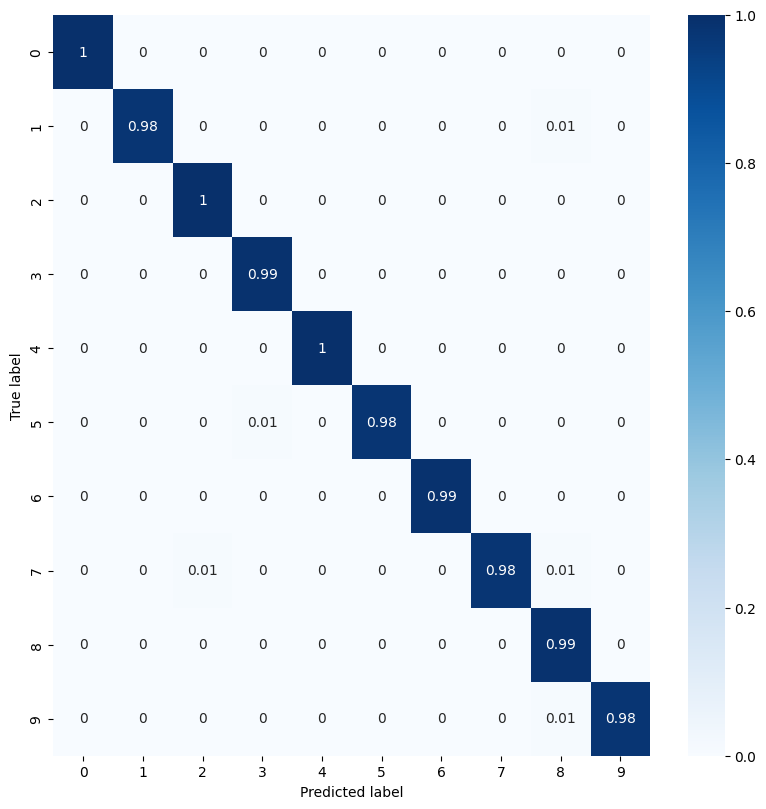

In [13]:
# Plot confusion matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

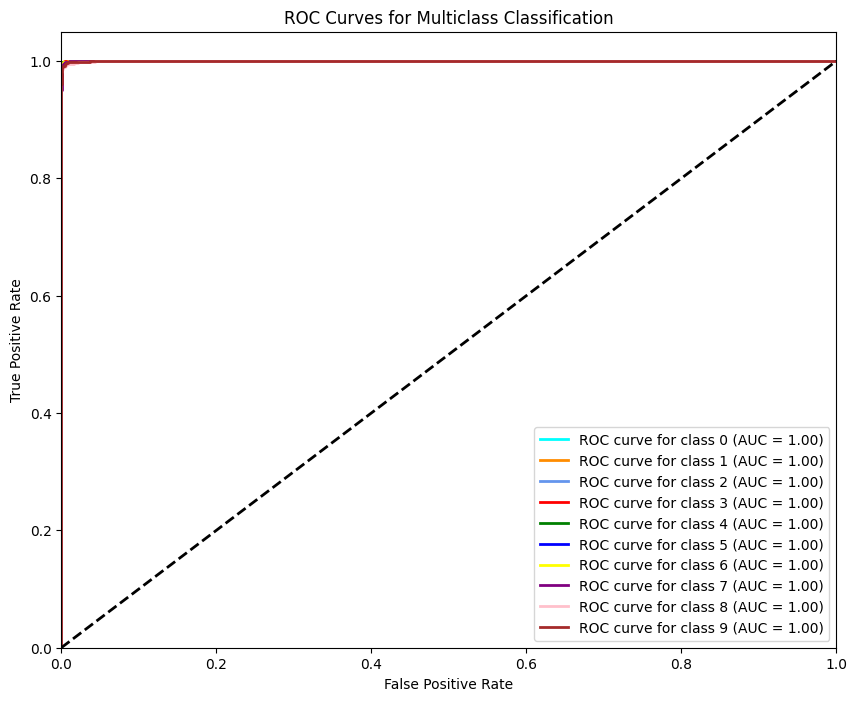

In [14]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'yellow', 'purple', 'pink', 'brown'])

for i, color in zip(range(len(classes)), colors):
    # Binarize the labels for each class
    y_true_binary = (y_true == i).astype(int)
    y_score = y_pred_probs[:, i]

    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve for class {0} (AUC = {1:0.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()